# Example Experiment
> Experiment using Repeated MNIST and BatchBALD vs BALD vs random sampling

This notebook ties everything together and runs an AL loop.

In [8]:
import blackhc.project.script
from tqdm.auto import tqdm

In [9]:
import torch
import math
from torch import nn as nn
from torch.nn import functional as F

from batchbald_redux import active_learning, batchbald, consistent_mc_dropout, joint_entropy, repeated_mnist

Let's define our Bayesian CNN model that we will use to train MNIST.

In [10]:
class BayesianCNN(consistent_mc_dropout.BayesianModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv1_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.fc1 = nn.Linear(1024, 128)
        self.fc1_drop = consistent_mc_dropout.ConsistentMCDropout()
        self.fc2 = nn.Linear(128, num_classes)

    def mc_forward_impl(self, input: torch.Tensor):
        input = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(input)), 2))
        input = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(input)), 2))
        input = input.view(-1, 1024)
        input = F.relu(self.fc1_drop(self.fc1(input)))
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)

        return input

Grab our dataset, we'll use Repeated-MNIST.

In [11]:
train_dataset, test_dataset = repeated_mnist.create_repeated_MNIST_dataset(num_repetitions=1, add_noise=False)

In [12]:
num_initial_samples = 20
num_classes = 10

initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset),
    num_classes=num_classes,
    n_per_digit=num_initial_samples/num_classes)

In [14]:
# experiment
max_training_samples = 150
acquisition_batch_size = 5
num_inference_samples = 100
num_test_inference_samples = 5
num_samples = 100000

test_batch_size = 512
batch_size = 64
scoring_batch_size = 128
epoch_samples = 4096 * 6

use_cuda = torch.cuda.is_available()

print(f"use_cuda: {use_cuda}")

device = "cuda" if use_cuda else "cpu"

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=False,
                                          **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(40000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(
        active_learning_data.training_dataset, epoch_samples),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(active_learning_data.pool_dataset,
                                          batch_size=scoring_batch_size,
                                          shuffle=False,
                                          **kwargs)

# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset),
            total=max_training_samples,
            desc="Training Set Size")

while True:
    model = BayesianCNN(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = model(data, 1).squeeze(1)
        loss = F.nll_loss(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = torch.logsumexp(
                model(data, num_test_inference_samples),
                dim=1) - math.log(num_test_inference_samples)
            loss += F.nll_loss(prediction, target, reduction="sum")

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
        loss, correct, len(test_loader.dataset), percentage_correct))

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire pool predictions
    N = len(active_learning_data.pool_dataset)
    logits_N_K_C = torch.empty((N, num_inference_samples, num_classes),
                               dtype=torch.double,
                               pin_memory=use_cuda)

    with torch.no_grad():
        model.eval()

        for i, (data, _) in enumerate(
                tqdm(pool_loader,
                     desc="Evaluating Acquisition Set",
                     leave=False)):
            data = data.to(device=device)

            lower = i * pool_loader.batch_size
            upper = min(lower + pool_loader.batch_size, N)
            logits_N_K_C[lower:upper].copy_(model(
                data, num_inference_samples).double(),
                                            non_blocking=True)

    with torch.no_grad():
        candidate_batch = batchbald.get_batchbald_batch(logits_N_K_C,
                                                        acquisition_batch_size,
                                                        num_samples,
                                                        dtype=torch.double,
                                                        device=device)

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(
        candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

use_cuda: True


Test set: Average loss: 1.8308, Accuracy: 6338/10000 (63.38%)


Dataset indices:  [ 8289  3582 53863 25823  8257]
Scores:  [1.3557736757796552, 2.519825665002863, 3.4085050062563003, 3.9695525038521966, 4.2919329737575325]
Labels:  tensor([0, 2, 3, 0, 2])


Test set: Average loss: 1.4175, Accuracy: 6985/10000 (69.85%)


Dataset indices:  [52012 41383 13682 42198  6185]
Scores:  [1.3061743472090992, 2.3644483581086218, 3.221506615442796, 3.8194846029077567, 4.183660860241003]
Labels:  tensor([8, 0, 8, 4, 3])


Test set: Average loss: 1.2743, Accuracy: 7269/10000 (72.69%)


Dataset indices:  [11657 37137 14866 28222 34614]
Scores:  [1.2659351842478004, 2.3131665302748754, 3.202945514749244, 3.8116075718264586, 4.159970164562334]
Labels:  tensor([0, 5, 7, 6, 2])


Test set: Average loss: 1.1519, Accuracy: 7435/10000 (74.35%)


Dataset indices:  [39411 13642 19396  8488 16077]
Scores:  [1.3163655603620135, 2.405610005940731, 3.1817393501560343, 3.758214079939448, 4.122080265207265]
Labels:  tensor([2, 5, 5, 6, 6])


Test set: Average loss: 0.9635, Accuracy: 7809/10000 (78.09%)


Dataset indices:  [40057  4606 55743 26444 37870]
Scores:  [1.209489071500093, 2.283754189343815, 3.102376195203646, 3.6698826219743843, 4.038958571081122]
Labels:  tensor([5, 9, 3, 1, 8])


Test set: Average loss: 0.7743, Accuracy: 8067/10000 (80.67%)


Dataset indices:  [ 2748 25910 24223 32954 20110]
Scores:  [1.123391331671529, 2.140858614880564, 3.012231409824741, 3.66999233531654, 4.095480093557085]
Labels:  tensor([2, 1, 8, 5, 4])


Test set: Average loss: 0.6680, Accuracy: 8267/10000 (82.67%)


Dataset indices:  [56615 37249 50461   384 32509]
Scores:  [1.2427624719236614, 2.2830006810904986, 3.1605394537163587, 3.7497607635339576, 4.128859502902091]
Labels:  tensor([3, 5, 7, 7, 8])


Test set: Average loss: 0.6514, Accuracy: 8397/10000 (83.97%)


Dataset indices:  [47695 30925 50010  3916 45114]
Scores:  [1.190816694089635, 2.2611525375451773, 3.0947280938353208, 3.7115958775092626, 4.084116729465448]
Labels:  tensor([4, 2, 5, 7, 7])


Test set: Average loss: 0.5701, Accuracy: 8386/10000 (83.86%)


Dataset indices:  [38760 54950  6578 52959 44590]
Scores:  [1.1627632250527844, 2.151829399286887, 2.9537553798530665, 3.559596661670692, 3.9736198748141387]
Labels:  tensor([9, 8, 6, 2, 7])


Test set: Average loss: 0.5139, Accuracy: 8582/10000 (85.82%)


Dataset indices:  [12281 20820 20859 29132 52972]
Scores:  [1.1276134714636667, 2.1698819851983324, 3.0257048656424925, 3.6544162493463603, 4.056693027547438]
Labels:  tensor([2, 9, 8, 8, 3])


Test set: Average loss: 0.5993, Accuracy: 8367/10000 (83.67%)


Dataset indices:  [49202 59080 19590 14699 11295]
Scores:  [1.0977984880766969, 2.0814510505992336, 2.908458520545308, 3.517485210170112, 3.926052066453105]
Labels:  tensor([5, 9, 5, 9, 0])


Test set: Average loss: 0.5477, Accuracy: 8621/10000 (86.21%)


Dataset indices:  [17756 42467 49580 34902 14705]
Scores:  [1.2460383110021542, 2.2770103994311666, 3.181935528898873, 3.7992051764099135, 4.157236509734414]
Labels:  tensor([8, 8, 2, 2, 0])


Test set: Average loss: 0.6217, Accuracy: 8466/10000 (84.66%)


Dataset indices:  [28860 17010  5217 47426 25117]
Scores:  [1.1420065931224535, 2.163338791178303, 3.0353145026285113, 3.689406154914269, 4.095223498725142]
Labels:  tensor([4, 3, 4, 3, 8])


Test set: Average loss: 0.4452, Accuracy: 8754/10000 (87.54%)


Dataset indices:  [59674 40066 29303 30878 43852]
Scores:  [1.0879233508208421, 2.083260109080535, 2.9151471744333244, 3.5294256346467683, 3.9514164379630943]
Labels:  tensor([4, 4, 8, 6, 2])


Test set: Average loss: 0.4564, Accuracy: 8763/10000 (87.63%)


Dataset indices:  [59314 53260 52697 27356  8668]
Scores:  [1.0931448747101902, 2.09011830748354, 2.9307625527521264, 3.570223588524582, 4.0151883704296445]
Labels:  tensor([9, 4, 3, 2, 5])


Test set: Average loss: 0.4157, Accuracy: 8803/10000 (88.03%)


Dataset indices:  [24440 59390 18412 32178  5852]
Scores:  [1.0443426003599554, 2.0138641259236483, 2.86321617007789, 3.505478145903256, 3.9422873447609907]
Labels:  tensor([0, 2, 0, 4, 3])


Test set: Average loss: 0.3696, Accuracy: 8889/10000 (88.89%)


Dataset indices:  [31184 47652  5129 28731 51261]
Scores:  [1.0962478190100569, 2.085744839210468, 2.9357022931217345, 3.5651083882428876, 3.9906569316999683]
Labels:  tensor([9, 2, 2, 2, 4])


Test set: Average loss: 0.3524, Accuracy: 9009/10000 (90.09%)


Dataset indices:  [39151 25387 31637 56391 22675]
Scores:  [1.0255197078227165, 1.9606027634150682, 2.749715548469969, 3.369155913082033, 3.815295016054319]
Labels:  tensor([4, 8, 5, 3, 3])


Test set: Average loss: 0.3498, Accuracy: 8994/10000 (89.94%)


Dataset indices:  [40766 35638  7768 21390 13021]
Scores:  [1.1270052748144128, 2.1798424784191712, 3.040212246578937, 3.635184434645347, 4.036560647852484]
Labels:  tensor([4, 2, 8, 3, 5])


Test set: Average loss: 0.3283, Accuracy: 9124/10000 (91.24%)


Dataset indices:  [44202 26034  2765 36818 29489]
Scores:  [1.0196356716784996, 1.9834245958639172, 2.7933227652841905, 3.41448235566454, 3.85158791628092]
Labels:  tensor([8, 5, 0, 7, 6])


Test set: Average loss: 0.2814, Accuracy: 9234/10000 (92.34%)


Dataset indices:  [37293 18398 33126 43126 30454]
Scores:  [1.1300931680857567, 2.1483018935070217, 2.992901494349929, 3.5947497233707892, 3.9926906528787685]
Labels:  tensor([3, 4, 9, 3, 6])


Test set: Average loss: 0.2732, Accuracy: 9264/10000 (92.64%)


Dataset indices:  [23086 37414  3070  8214  3218]
Scores:  [1.054147318045934, 2.0399407506273706, 2.8545137655874995, 3.479438083830503, 3.9201075658821574]
Labels:  tensor([8, 5, 1, 7, 4])


Test set: Average loss: 0.2742, Accuracy: 9282/10000 (92.82%)


Dataset indices:  [35864 29899 37655 24620  7923]
Scores:  [1.0425523144612032, 1.9722955492461425, 2.769826348292811, 3.409673106042364, 3.855570195163713]
Labels:  tensor([5, 3, 2, 9, 8])


Test set: Average loss: 0.2854, Accuracy: 9261/10000 (92.61%)


Dataset indices:  [43206  5315 38509 40466 28512]
Scores:  [1.0095551073232742, 1.9773855734476835, 2.7935712557665253, 3.4312428375675297, 3.859673478664067]
Labels:  tensor([5, 3, 2, 8, 5])


Test set: Average loss: 0.3089, Accuracy: 9146/10000 (91.46%)


Dataset indices:  [34946 34520 49523 53873 33812]
Scores:  [1.0336427348167723, 1.9970519915069573, 2.797597657927694, 3.42035327890408, 3.8533839231792015]
Labels:  tensor([8, 6, 7, 4, 6])


Test set: Average loss: 0.3097, Accuracy: 9186/10000 (91.86%)


Dataset indices:  [44898  2761 57882 50317 41453]
Scores:  [0.9905177855898044, 1.9297613872862898, 2.7047249345431563, 3.3479105773782156, 3.7841506750832803]
Labels:  tensor([2, 8, 0, 3, 3])


Test set: Average loss: 0.2967, Accuracy: 9241/10000 (92.41%)


In [31]:
# hide
test_accs

[63.38,
 69.85,
 72.69,
 74.35,
 78.09,
 80.67,
 82.67,
 83.97,
 83.86,
 85.82,
 83.67,
 86.21,
 84.66,
 87.54,
 87.63,
 88.03,
 88.89,
 90.09,
 89.94,
 91.24,
 92.34,
 92.64,
 92.82,
 92.61,
 91.46,
 91.86,
 92.41]

In [16]:
# hide
test_loss

[tensor(1.8308, device='cuda:0'),
 tensor(1.4175, device='cuda:0'),
 tensor(1.2743, device='cuda:0'),
 tensor(1.1519, device='cuda:0'),
 tensor(0.9635, device='cuda:0'),
 tensor(0.7743, device='cuda:0'),
 tensor(0.6680, device='cuda:0'),
 tensor(0.6514, device='cuda:0'),
 tensor(0.5701, device='cuda:0'),
 tensor(0.5139, device='cuda:0'),
 tensor(0.5993, device='cuda:0'),
 tensor(0.5477, device='cuda:0'),
 tensor(0.6217, device='cuda:0'),
 tensor(0.4452, device='cuda:0'),
 tensor(0.4564, device='cuda:0'),
 tensor(0.4157, device='cuda:0'),
 tensor(0.3696, device='cuda:0'),
 tensor(0.3524, device='cuda:0'),
 tensor(0.3498, device='cuda:0'),
 tensor(0.3283, device='cuda:0'),
 tensor(0.2814, device='cuda:0'),
 tensor(0.2732, device='cuda:0'),
 tensor(0.2742, device='cuda:0'),
 tensor(0.2854, device='cuda:0'),
 tensor(0.3089, device='cuda:0'),
 tensor(0.3097, device='cuda:0'),
 tensor(0.2967, device='cuda:0')]

In [17]:
# hide
added_indices

[array([ 8289,  3582, 53863, 25823,  8257]),
 array([52012, 41383, 13682, 42198,  6185]),
 array([11657, 37137, 14866, 28222, 34614]),
 array([39411, 13642, 19396,  8488, 16077]),
 array([40057,  4606, 55743, 26444, 37870]),
 array([ 2748, 25910, 24223, 32954, 20110]),
 array([56615, 37249, 50461,   384, 32509]),
 array([47695, 30925, 50010,  3916, 45114]),
 array([38760, 54950,  6578, 52959, 44590]),
 array([12281, 20820, 20859, 29132, 52972]),
 array([49202, 59080, 19590, 14699, 11295]),
 array([17756, 42467, 49580, 34902, 14705]),
 array([28860, 17010,  5217, 47426, 25117]),
 array([59674, 40066, 29303, 30878, 43852]),
 array([59314, 53260, 52697, 27356,  8668]),
 array([24440, 59390, 18412, 32178,  5852]),
 array([31184, 47652,  5129, 28731, 51261]),
 array([39151, 25387, 31637, 56391, 22675]),
 array([40766, 35638,  7768, 21390, 13021]),
 array([44202, 26034,  2765, 36818, 29489]),
 array([37293, 18398, 33126, 43126, 30454]),
 array([23086, 37414,  3070,  8214,  3218]),
 array([35

In [19]:
# hide
# experiment
!pip install matplotlib

     |████████████████████████████████| 12.4 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 10.6 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


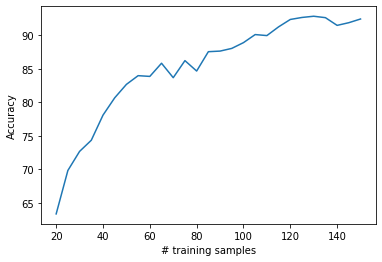

In [32]:
# experiment 
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs)
plt.xlabel("# training samples")
plt.ylabel("Accuracy")
plt.show()